This notebook uses YOLOv4.

In [2]:
import os
import numpy as np
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import albumentations as A
from tqdm import tqdm
import cv2 as cv

## Classes

In [3]:
classes = ["cloth", "KN95","N95", "surgical"]

## Format helper functions

In [4]:
def convert_bbox_to_yolo(bbox, img_size=(512, 512)):
    x = (bbox[0]+bbox[2])/(2.0*img_size[0])
    y = (bbox[1]+bbox[3])/(2.0*img_size[1])  
    w = (bbox[2]-bbox[0])/(img_size[0])
    h = (bbox[3]-bbox[1])/(img_size[1])
    return [x,y,w,h]


In [5]:
def convert_bbox_to_pascal(bbox, img_size=(512, 512)):
    xmin = (bbox[0]-bbox[2]/2.0)*img_size[0]
    ymin = (bbox[1]-bbox[3]/2.0)*img_size[1]
    xmax = (bbox[0]+bbox[2]/2.0)*img_size[0]
    ymax = (bbox[1]+bbox[3]/2.0)*img_size[1]
    return [xmin,ymin,xmax,ymax]


In [141]:
def visualize(img_info, path, with_hsv=False):
    img_name = path + img_info["ImageID"] + ".jpg"
    bbox = eval(img_info["bbox"])
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    [x1, y1, x2, y2] = [int(coord) for coord in bbox]
    cv.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.imshow(img)
    if with_hsv:
        hsv_thresholding(img, show=True)

In [7]:
def show_suspected(img_name, path, bbox):
    img_name = path + img_name + ".jpg"
    img = cv.imread(img_name)
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    [x1, y1, x2, y2] = [int(coord) for coord in bbox]
    cv.rectangle(img, (x1, y1), (x2, y2), (255,0,0), 2)
    plt.imshow(img)
    plt.show()        

In [161]:
def hsv_thresholding(img, min_hue=0.57, max_hue=0.6, show=False):
    sample_h = rgb2hsv(img)
    # HSV
    sample_h= rgb2hsv(img)
    if show:
        fig, ax = plt.subplots(1, 3, figsize=(15,5))
        hsv = ax[0].imshow(sample_h[:,:,0], cmap='hsv')
        ax[0].set_title('Hue',fontsize=15)
        plt.colorbar(hsv, ax=ax[0])
        ax[1].imshow(sample_h[:,:,1], cmap='hsv')
        ax[1].set_title('Saturation',fontsize=15)
        ax[2].imshow(sample_h[:,:,2], cmap='hsv')
        ax[2].set_title('Value',fontsize=15);
        plt.show()
    # mask
    #set the lower and upper mask based on hue colorbar value
    lower_mask = sample_h[:,:,0] > min_hue
    upper_mask = sample_h[:,:,0] < max_hue
    mask = upper_mask*lower_mask

    rows, cols = np.nonzero(img[:,:,2]*mask)
    color = np.mean(img[rows, cols])
    if color < 175:
        if color < 135:
            label = classes[0]
        else:
            label = classes[3]
    else:
        if color < 186:
            label = classes[2]
        else:
            label = classes[1]
    
    # get the desired mask and show in original image
    red = img[:,:,0]*mask
    green = img[:,:,1]*mask
    blue = img[:,:,2]*mask
    mask2 = np.dstack((red,green,blue))
    
    mask_gray = cv.cvtColor(mask2, cv.COLOR_RGB2GRAY)
    ret, threshold = cv.threshold(mask_gray, 100, 255, 0)
    
    if show:
        print(color)
        plt.imshow(mask2)
        plt.show()
        plt.imshow(threshold, cmap="gray")
        plt.show()
        
    return threshold, label

In [114]:
def find_greatest_contour(mask_gray):
    contours, hierarchy = cv.findContours(mask_gray,cv.RETR_TREE,cv.CHAIN_APPROX_SIMPLE)
    max_area = 0
    max_contour = contours[0]
    for contour in contours:
        area = cv.contourArea(contour)
        if area > max_area:
            max_area = area
            max_contour = contour
    return max_contour

In [115]:
def find_bbox_from_contour(contour):
    cpoly = cv.approxPolyDP(contour, 0.1, True)
    box = 	cv.boundingRect(cpoly)
    return [box[0], box[1], box[0]+box[2], box[1]+box[3]]

In [160]:
def encodeBoxes(tensor_boxes, name, score_thr=0.5):
    boxes = tensor_boxes["boxes"]
    scores = tensor_boxes["scores"]
    labels = tensor_boxes["labels"]
    bboxes = boxes[scores > score_thr]
    label = labels[scores > score_thr]
    if len(bboxes) >= 1:
        bboxes = bboxes[0].tolist()
        label = label[0]
    else:
        print(name, scores, labels)
        if len(scores) == 0:
            img = cv.imread(path+"/data/test/"+name+".jpg")
            img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
            plt.imshow(img)
            plt.show()
            mask_gray, label = hsv_thresholding(img)
            contour = find_greatest_contour(mask_gray)
            bboxes = find_bbox_from_contour(contour)
            show_suspected(name, path+"/data/test/", bboxes)
            print(label)
        else:
            show_suspected(name, path+"/data/test/", boxes[0])
            bboxes = boxes[0].tolist()
            label = labels[0]
    return bboxes, label

## Augmentation

In [7]:
train_transform = A.Compose([
    A.augmentations.crops.transforms.RandomResizedCrop(512, 512, p=0.5),
    A.augmentations.geometric.transforms.Perspective(),
    A.augmentations.transforms.HorizontalFlip(),
    A.augmentations.geometric.transforms.ShiftScaleRotate(border_mode=0)], 
    bbox_params=A.BboxParams(format='yolo', min_visibility=0.1, label_fields=["labels"]))

In [8]:
def transform(img, annot, transform, bdboxes, labels, new_folder="data/aug/"):
    image = cv.imread(img)
    txt_file = img.replace("png","txt")

    transformed = transform(image=image, bboxes=bdboxes, labels=labels)
    image = transformed["image"]
    new_img = img.replace("data/train/", new_folder)
    cv.imwrite(new_img.replace(".jpg", annot+".jpg"), image)
    bboxes = transformed["bboxes"]
    labels = transformed["labels"]
    res_file = new_img.replace(".jpg", annot+".txt")
    with open(res_file, 'w') as res:
        for i in range(len(labels)):
            res.write(str(int(labels[i])))
            for j in range(len(bboxes[i])):
                res.write(" "+str(bboxes[i][j]))
            res.write("\n")

## Prepare data

In [128]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")

In [129]:
train_df.head()

,ImageID,bbox,masktype
0,k8o0f,"[73, 197, 293, 400]",N95
1,7a0l9,"[47, 364, 300, 512]",surgical
2,wfp7p,"[203, 221, 380, 403]",N95
3,7qaw6,"[87, 210, 322, 385]",surgical
4,i4kqj,"[227, 283, 479, 475]",surgical


### Save and augment train data

In [9]:
path = os.path.abspath(os.getcwd())

In [12]:
for idx, row in tqdm(train_df.iterrows(), total=train_df.shape[0]):
    box = eval(row["bbox"])
    bbox = convert_bbox_to_yolo(box)
    label = classes.index(row["masktype"])
    with open( 'data/train/' + row["ImageID"] + '.txt', 'w') as output_file:
        output_file.write("{}".format(label))
        for coord in bbox:
            output_file.write(" {}".format(coord))
        output_file.write("\n")
    transform('data/train/' + row["ImageID"] + '.jpg', "_transformed", train_transform, np.array([bbox]), np.array([label]))

100%|██████████| 5600/5600 [01:05<00:00, 85.88it/s] 


In [13]:
trainfiles = [path+"/data/train/{}.jpg".format(img) for img in train_df["ImageID"].tolist()]
augmentedfiles = [path+"/data/aug/{}_transformed.jpg".format(img) for img in train_df["ImageID"].tolist()]
trainfiles = trainfiles + augmentedfiles

with open("data/train.txt", 'w') as f:
    for file in trainfiles:
        f.write(file+"\n")

### Save validation data

In [14]:
for idx, row in tqdm(val_df.iterrows(), total=val_df.shape[0]):
    box = eval(row["bbox"])
    bbox = convert_bbox_to_yolo(box)
    label = classes.index(row["masktype"])
    with open( 'data/val/' + row["ImageID"] + '.txt', 'w') as output_file:
        output_file.write("{}".format(label))
        for coord in bbox:
            output_file.write(" {}".format(coord))
        output_file.write("\n")

100%|██████████| 2400/2400 [00:00<00:00, 8673.21it/s]


In [15]:
valfiles = [path+"/data/val/{}.jpg".format(img) for img in val_df["ImageID"].tolist()]

with open("data/val.txt", 'w') as f:
    for file in valfiles:
        f.write(file+"\n")

### Prepare test images' names

In [10]:
test_df = pd.read_csv("data/sample_submission.csv")

In [11]:
test_df.head()

,ImageID,bbox,masktype
0,os9el,"[0, 0, 0, 0]",NaN
1,gksn6,"[0, 0, 0, 0]",NaN
2,odcws,"[0, 0, 0, 0]",NaN
3,04qsi,"[0, 0, 0, 0]",NaN
4,6canb,"[0, 0, 0, 0]",NaN


In [ ]:
testfiles = [path+"/data/test/{}.jpg".format(img) for img in test_df["ImageID"].tolist()]

with open("data/test.txt", 'w') as f:
    for file in testfiles:
        f.write(file+"\n")

## Get anchors

In [ ]:
%%bash
cd darknet
./darknet detector calc_anchors obj.data -num_of_clusters 9 -width 512 -height 512

## HSV thresholding

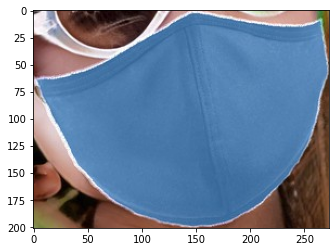

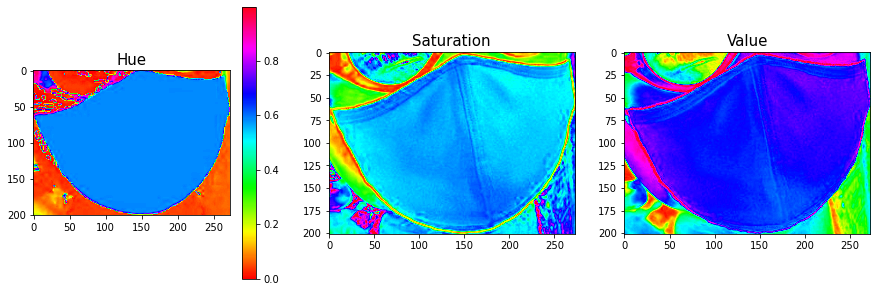

126.20479530555174


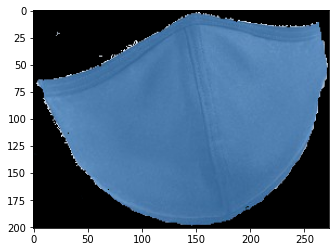

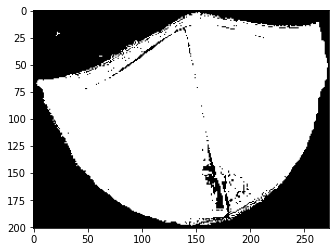

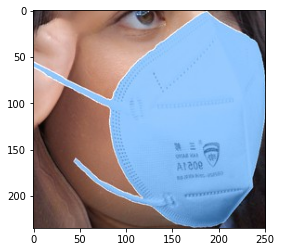

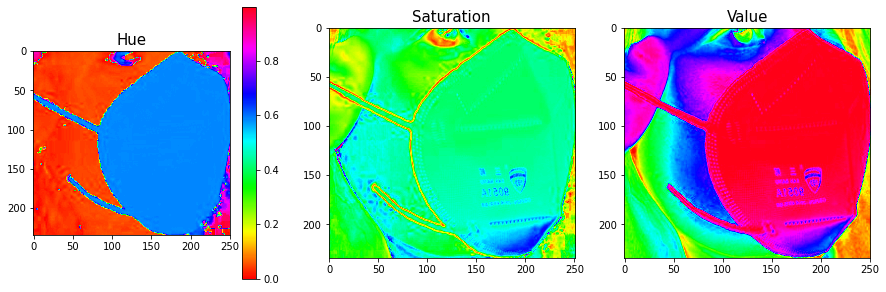

190.13029768051254


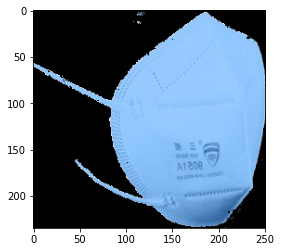

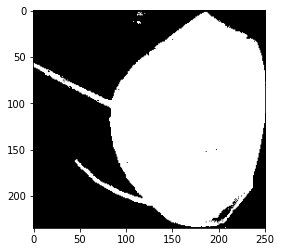

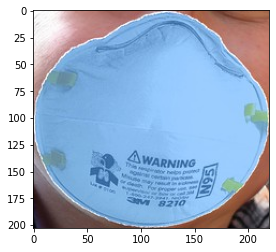

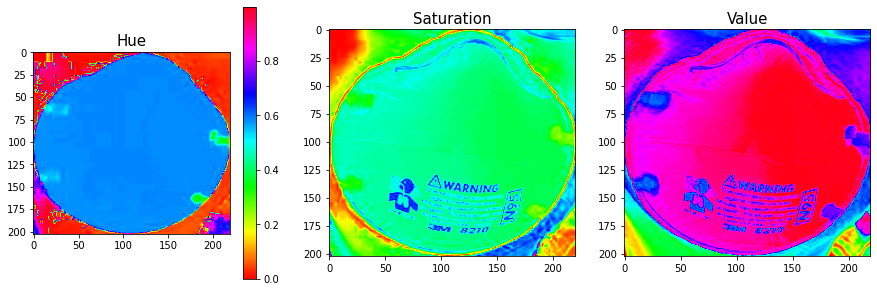

182.51176189718288


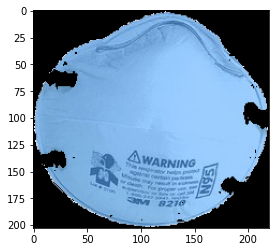

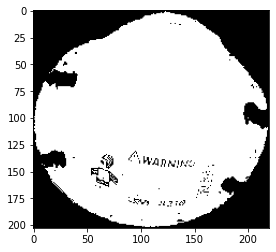

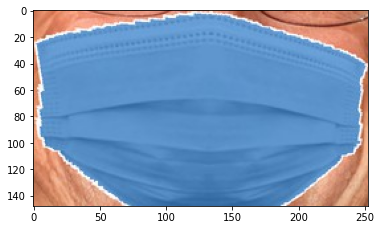

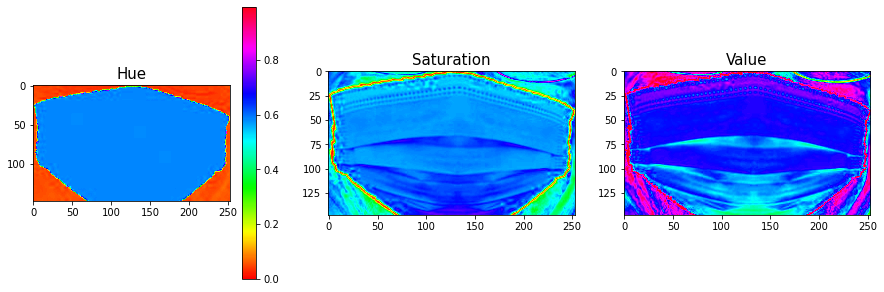

143.1748473581881


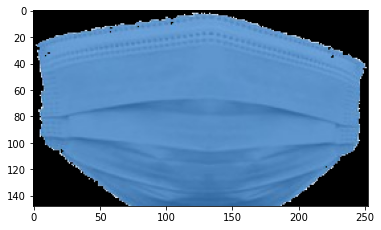

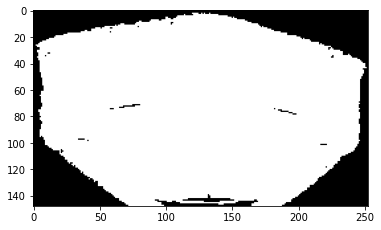

In [162]:
for masktype in classes:
    img = cv.imread(os.path.join("data/train/", train_df["ImageID"][train_df[train_df["masktype"]==masktype].index[0]]+".jpg"))
    bbox = eval(train_df["bbox"][train_df[train_df["masktype"]==masktype].index[0]])
    img = cv.cvtColor(img, cv.COLOR_RGB2BGR)
    [x1, y1, x2, y2] = [int(coord) for coord in bbox]
    img = img[bbox[1]:bbox[3],bbox[0]:bbox[2]]
    plt.imshow(img)
    plt.show()
    hsv_thresholding(img, show=True)

## Train

In [ ]:
%%bash
cd darknet
./darknet detector train obj.data yolo-obj.cfg yolov4.conv.137 -map -gpus 3 -dont_show -mjpeg_port 18989

## Get results

In [ ]:
%%bash
cd darknet
./darknet detector test obj.data yolo-obj.cfg backup/yolo-obj_best.weights \
-dont_show -ext_output < data/test.txt \
                          -out result.json 

In [12]:
import json
with open("result.json") as file:
    result = json.load(file)

In [13]:
from skimage.color import rgb2hsv

 53%|█████▎    | 1055/2000 [00:00<00:00, 1798.06it/s]

k4bad [] []


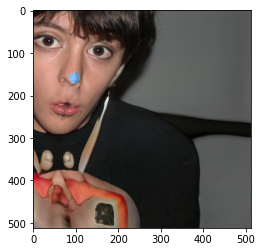

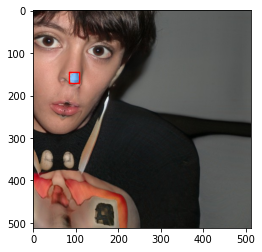

 62%|██████▏   | 1235/2000 [00:01<00:00, 882.59it/s] 

cloth
l211c [] []


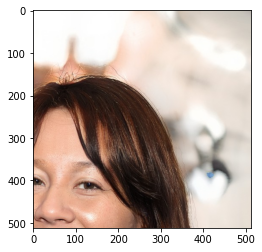

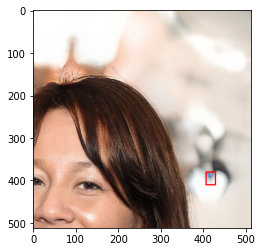

 77%|███████▋  | 1547/2000 [00:01<00:00, 790.62it/s]

N95


100%|██████████| 2000/2000 [00:01<00:00, 1128.44it/s]


In [163]:
for i in tqdm(range(len(result))):
    img_name = result[i]["filename"].replace(path+"/data/test/", "").replace(".jpg", "")
    scores = []
    boxes = []
    labels = []
    for obj in result[i]["objects"]:
        labels.append(obj["name"])
        scores.append(float(obj["confidence"]))
        coords = [obj["relative_coordinates"][coord] for coord in obj["relative_coordinates"]]
        
        coordinates = convert_bbox_to_pascal(coords)
        boxes.append(coordinates)

    scores = np.asarray(scores)
    boxes = np.asarray(boxes)
    labels = np.asarray(labels)
    preds = {"scores":scores, "boxes":boxes, "labels": labels}
    box, masktype = encodeBoxes(preds, img_name, 0.2)
    test_df.loc[test_df['ImageID'] == img_name, "bbox"] = str(box)
    test_df.loc[test_df['ImageID'] == img_name, "masktype"] = masktype

In [164]:
test_df.head()

,ImageID,bbox,masktype
0,os9el,"[120.54630399999999, 341.971456, 396.039168, 5...",cloth
1,gksn6,"[178.71974400000002, 190.27507199999997, 479.5...",N95
2,odcws,"[274.00985599999996, 283.56710400000003, 498.7...",cloth
3,04qsi,"[59.620608000000004, 187.92319999999998, 304.3...",surgical
4,6canb,"[198.85465600000003, 299.520768, 444.270592, 4...",KN95


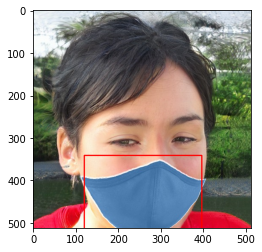

In [165]:
visualize(test_df.iloc[0], path+"/data/test/")

In [166]:
test_df.to_csv("submission.csv", index=False)